# LASSO Linear Regression

Shape of X: (100000, 3)
Shape of y: (100000, 3)
Total samples: 100000

LASSO Coefficients:
[[0.43751866 0.01066732 0.        ]
 [0.43217719 0.47383226 0.        ]
 [0.43951119 0.         0.46566895]]

Optimal alpha from CV: 0.000111

Estimated Coefficients (MultiTaskLassoCV):
[[ 0.49883862  0.04224484 -0.00125896]
 [ 0.49359182  0.50544959 -0.00155439]
 [ 0.50130576 -0.00159007  0.49870765]]


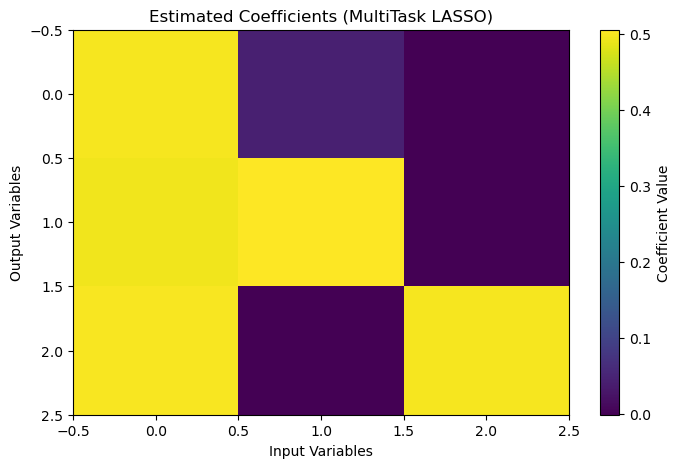

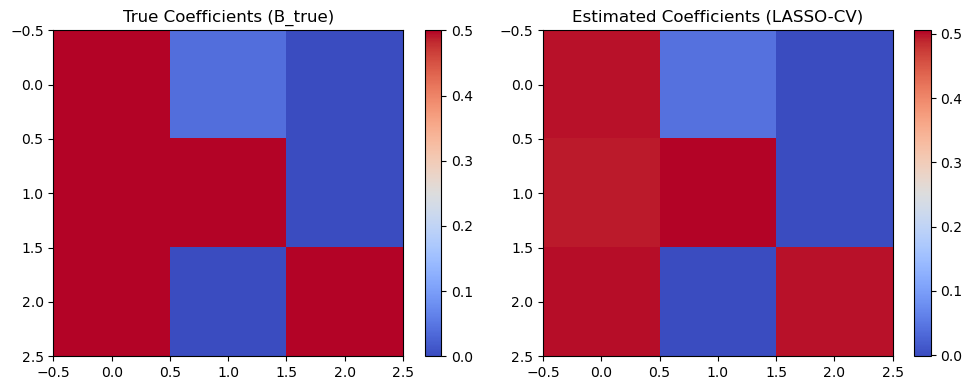

In [2]:
# -------------------------------------------------------------
# LINK LASSO REGRESSION
# -------------------------------------------------------------
# Author: Davide Rossetti
# Description:
# Simulation of a three-variable stochastic system and recovery 
# of coupling parameters using LASSO regression.
# The goal is to infer the structure of the dynamic links 
# between variables from noisy data.
# -------------------------------------------------------------

# === Import libraries ===
import numpy as np
import math
from scipy import linalg
from sklearn.linear_model import Lasso, MultiTaskLassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Simulation parameters ===
mu, sigma = 0, 1        # mean and std. deviation for Gaussian noise
a = 0.5                 # coupling strength parameter
b = 1                   # noise amplitude
transtime = 2000        # transient time (to reach steady state)
time = 2_500_000        # total number of time steps
eps = 0.04              # small coupling coefficient between variables

# === Initialize system matrix ===
M = np.zeros((3, time))  # matrix containing system trajectories

# Initial conditions (random)
M[0, 0] = np.random.normal(mu, sigma)
M[1, 0] = np.random.normal(mu, sigma)
M[2, 0] = np.random.normal(mu, sigma)

# === Transient dynamics (system evolution before recording) ===
for t in range(transtime):
    # Random Gaussian noise terms
    etaxt = b * np.random.normal(mu, sigma)
    etayt = b * np.random.normal(mu, sigma)
    etazt = b * np.random.normal(mu, sigma)

    # Short variable names for clarity
    var = M[0, 0]
    var1 = M[1, 0]
    var2 = M[2, 0]

    # Linear coupling update rules
    M[0, 0] = a * var + eps * var1 + etaxt
    M[1, 0] = a * var + a * var1 + etayt
    M[2, 0] = a * var + a * var2 + etazt

# === Main system evolution ===
for t in range(time - 1):
    etaxt = b * np.random.normal(mu, sigma)
    etayt = b * np.random.normal(mu, sigma)
    etazt = b * np.random.normal(mu, sigma)

    M[0, t + 1] = a * M[0, t] + eps * M[1, t] + etaxt
    M[1, t + 1] = a * M[0, t] + a * M[1, t] + etayt
    M[2, t + 1] = a * M[0, t] + a * M[2, t] + etazt

# === Build dataset matrices (features and targets) ===
A = np.zeros((time, 3))
for t in range(time):
    A[t, 0] = M[0, t]
    A[t, 1] = M[1, t]
    A[t, 2] = M[2, t]

tdec = 25  # downsampling step
y = np.zeros((int(time / tdec), 3))
X = np.zeros((int(time / tdec), 3))
i = 0

# Construct input-output pairs (X, y)
for t in range(0, time, tdec):
    X[i] = A[t]
    y[i] = A[t + 1]
    i += 1

print("Shape of X:", np.shape(X))
print("Shape of y:", np.shape(y))
print("Total samples:", i)

# === True coefficient matrix (for comparison) ===
B_true = np.array([[a, eps, 0],
                   [a, a, 0],
                   [a, 0, a]])

# -------------------------------------------------------------
# LASSO REGRESSION
# -------------------------------------------------------------
# Simple Lasso model (fixed regularization)
lasso = Lasso(alpha=0.1)

# Train the model
lasso.fit(X, y)

# Retrieve the estimated coefficients
coefficients = lasso.coef_

print("\nLASSO Coefficients:")
print(coefficients)

# -------------------------------------------------------------
# MULTI-TASK LASSO (Cross-Validated)
# -------------------------------------------------------------
# Automatically selects optimal alpha value through cross-validation
alphas = np.logspace(-6, -3.8, 100)
lasso_cv = MultiTaskLassoCV(alphas=alphas, cv=5)

# Train model with cross-validation
lasso_cv.fit(X, y)

# Extract optimal regularization parameter
best_alpha = lasso_cv.alpha_
print(f"\nOptimal alpha from CV: {best_alpha:.6f}")

# Estimated coefficient matrix
coefficients_cv = lasso_cv.coef_
print("\nEstimated Coefficients (MultiTaskLassoCV):")
print(coefficients_cv)

# -------------------------------------------------------------
# VISUALIZATION
# -------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.title("Estimated Coefficients (MultiTask LASSO)")
plt.imshow(coefficients_cv, cmap='viridis', aspect='auto')
plt.colorbar(label='Coefficient Value')
plt.xlabel("Input Variables")
plt.ylabel("Output Variables")
plt.show()

# Compare true vs estimated matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("True Coefficients (B_true)")
plt.imshow(B_true, cmap='coolwarm', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated Coefficients (LASSO-CV)")
plt.imshow(coefficients_cv, cmap='coolwarm', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()
